# SVM_16QAM Modulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sofa_sem import *

### Generación y modulación

In [2]:
Ns = 10000
Mod = 16 #16QAM
symbols_tx = np.random.randint(Mod, size=Ns)
df = pd.DataFrame()
df['tx'] = symbols_tx
df.head()

,tx
0,12
1,11
2,1
3,14
4,7


In [3]:
# Diccionario con el que se modulan los datos
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [4]:
# Modulación de los datos
df_tx = df.replace(mod_dict)
df_tx.head()

,tx
0,1.0+3.0j
1,3.0-1.0j
2,-3.0+1.0j
3,1.0-3.0j
4,-1.0-1.0j


## Adición de ruido AWGN para simular un canal real

In [5]:
Xr = np.real(df_tx['tx'])
Xi = np.imag(df_tx['tx'])

In [6]:
# Se generan varias intensidades de ruido AWGN y se agregan a los datos
target_snr_db = [i for i in np.arange(4, 25, 4)]
Xr_ch = [add_noise(Xr, i) for i in target_snr_db]
Xi_ch = [add_noise(Xi, i) for i in target_snr_db]

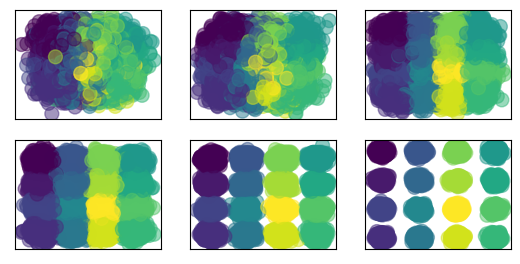

In [7]:
# Grafica de los datos extraidos del canal
for i in range(len(target_snr_db)):
    plt.subplot(3, 3, i + 1)
    plt.scatter(Xr_ch[i], Xi_ch[i], c=df['tx'], s=100, marker='o', alpha=0.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

## Demodulación convencional

In [8]:
# Se demapean los datos extraidos del canal con ruido
sym_rx = [demapper_sym(Xr_ch[i], Xi_ch[i], len(Xr_ch[i]), threshold = 2.0) for i in range(len(target_snr_db))]

In [9]:
ser_conventional = []
for i in range(len(target_snr_db)):
  SER, error = symbol_error_rate(df['tx'], sym_rx[i])
  ser_conventional.append(SER)

In [10]:
ber_conventional = []
for i in range(len(target_snr_db)):
  SER, error = bit_error_rate(df['tx'], sym_rx[i])
  ber_conventional.append(SER)

### Demodulación usando SVM

In [11]:
ber_svm = []
ber_svm_grid = []
for i in range(len(target_snr_db)):
    X = np.transpose(np.array([Xr_ch[i], Xi_ch[i]]))
    y = df['tx']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    model = SVC()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    ser, ser_error = symbol_error_rate(y_test, y_pred)
    ber, ber_error = bit_error_rate(y_test, y_pred)

    ber_svm.append(ber)

    param_grid = {'C':[0.01, 0.1, 1, 10, 100, 1000], 
                  'gamma':[1,0.1,0.01, 0.001, 0.0001, 0.00001]}
    
    grid = GridSearchCV(SVC(), param_grid, verbose=0)
    grid.fit(X_train, y_train)

    y_pred_grid = grid.predict(X_test)
    ser_grid, ser_grid_error = symbol_error_rate(y_test, y_pred_grid)
    ber_grid, ber_grid_error = bit_error_rate(y_test, y_pred_grid)

    ber_svm_grid.append(ber_grid)

    '''print('Accuracy:', metrics.accuracy_score(y_test, y_pred_grid), 
          f'| SER: {SER_test}, Error sym: {error_SER}', 
          f'| BER: {BER_test}, Error Bit: {error_BER} |', 
          grid.best_estimator_)'''

## Grafica del BER vs SNR

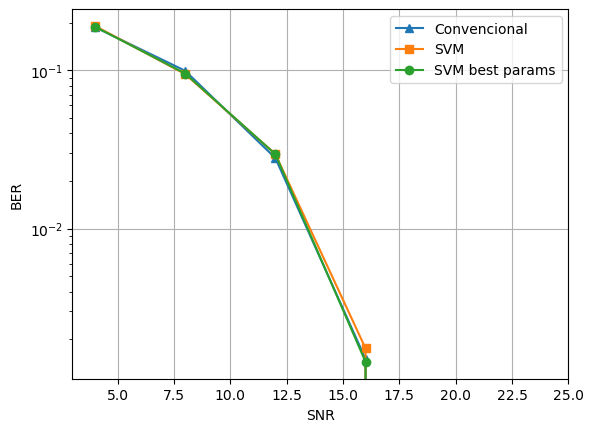

In [12]:
plt.plot(target_snr_db, ber_conventional, marker='^', label='Convencional')
plt.plot(target_snr_db, ber_svm, marker='s', label='SVM')
plt.plot(target_snr_db, ber_svm_grid, marker='o', label='SVM best params')
plt.xlabel('SNR')
plt.ylabel('BER')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()